Add imports

In [292]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import scipy
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import inception_v3

Setup gpu

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Set paths to data

In [194]:
TRAIN_CSV = './data/train.csv'
TRAIN_IMAGES_DIR = './data/train_images/'

Load csv using pandas

In [203]:
traindf = pd.read_csv(TRAIN_CSV, dtype=str)
traindf['labels'].value_counts()

0    800113bb65efe69e.jpg
1    8002cb321f8bfcdf.jpg
2    80070f7fb5e2ccaa.jpg
3    80077517781fb94f.jpg
4    800cbf0ff87721f8.jpg
5    800edef467d27c15.jpg
6    800f85dc5f407aef.jpg
7    801d6dcd96e48ebc.jpg
8    801f78399a44e7af.jpg
9    8021b94d437eb7d3.jpg
Name: image, dtype: object

Load images using ImageDataGenerator, copied from [StackOverflow](https://stackoverflow.com/questions/59464409/loading-images-in-keras-for-cnn-from-directory-but-label-in-csv-file)

In [261]:
shape = (256, 256, 3)
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255., validation_split=0.2)
train_generator = datagen.flow_from_dataframe(dataframe = traindf,
                                              directory = TRAIN_IMAGES_DIR,
                                              featurewise_std_normalization = True,
                                              x_col = 'image',
                                              y_col = 'labels',
                                              subset = 'training',
                                              batch_size = 32,
                                              seed = 1,
                                              shuffle = True,
                                              class_mode = 'categorical',
                                              target_size = shape[:2]
                                             )

validation_generator = datagen.flow_from_dataframe(dataframe = traindf,
                                              directory = TRAIN_IMAGES_DIR,
                                              featurewise_std_normalization = True,
                                              x_col = 'image',
                                              y_col = 'labels',
                                              subset = 'validation',
                                              batch_size = 32,
                                              seed = 1,
                                              shuffle = True,
                                              class_mode = 'categorical',
                                              target_size = shape[:2]
                                             )

Found 14906 validated image filenames belonging to 12 classes.
Found 3726 validated image filenames belonging to 12 classes.


In [262]:
train_images, train_labels = next(iter(train_generator))
val_images, val_labels = next(iter(validation_generator))

In [163]:
classes_amount = len(set(train_generator.classes))

### First model:

In [13]:
model = keras.Sequential(
  [
    keras.Input(shape=train_generator.image_shape),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes), # now the size of the last layer is 12, not 14906, so everything fits
  ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 196608)            0         
                                                                 
 dense (Dense)               (None, 128)               25165952  
                                                                 
 dense_1 (Dense)             (None, 12)                1548      
                                                                 
Total params: 25,167,500
Trainable params: 25,167,500
Non-trainable params: 0
_________________________________________________________________


2022-04-20 21:56:22.254525: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Compiling the model

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',#keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Training the model

In [ ]:
model.fit(train_generator, epochs=5)

### Second model:

Creating layers:

In [174]:
imagenet = inception_v3.InceptionV3(weights ='imagenet', include_top = False)
for layer in imagenet.layers:
    layer.trainable = False

model1 = keras.Sequential([
    keras.Input(shape = train_generator.image_shape),
    imagenet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(classes_amount, kernel_initializer = 'uniform', activation = "softmax")
])

model1.compile(loss = 'categorical_crossentropy',
               optimizer = 'Adam',
               metrics = ['accuracy'])

model1.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 global_average_pooling2d_13  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_20 (Dense)            (None, 12)                24588     
                                                                 
Total params: 21,827,372
Trainable params: 24,588
Non-trainable params: 21,802,784
_________________________________________________________________


Training model:

In [29]:
history = model1.fit(train_generator, 
                     epochs = 5,
                     verbose = 1)

Epoch 1/5
466/466 [==============================] - 1610s 3s/step - loss: 1.2694 - accuracy: 0.5896
Epoch 2/5
466/466 [==============================] - 1594s 3s/step - loss: 1.0445 - accuracy: 0.6617
Epoch 3/5
466/466 [==============================] - 1596s 3s/step - loss: 0.9705 - accuracy: 0.6821
Epoch 4/5
466/466 [==============================] - 1620s 3s/step - loss: 0.9219 - accuracy: 0.6956
Epoch 5/5
466/466 [==============================] - 1604s 3s/step - loss: 0.8876 - accuracy: 0.7086


In [30]:
model1.save(f"model/m1")

2022-04-21 00:19:51.771702: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model/m1/assets


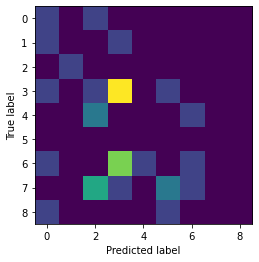

In [231]:
model_predictions = model1.predict(val_images)

y_true = [np.argmax(row) for row in val_labels]
y_pred = [np.argmax(row) for row in model_predictions]

matrix = confusion_matrix(y_true, y_pred)

plt.imshow(matrix)

plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

In [226]:
print("Evaluate")
result = model1.evaluate(validation_generator)
dict(zip(model1.metrics_names, result))

Evaluate
30/30 [==============================] - 102s 3s/step - loss: 2.4001 - accuracy: 0.1611


{'loss': 2.400103807449341, 'accuracy': 0.1611170768737793}

### Third model:

In [257]:
intercept_layer = inception_v3.InceptionV3(weights ='imagenet', include_top = False)
for layer in intercept_layer.layers:
    layer.trainable = False

imput_layer = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=shape),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
])
    
model2 = keras.Sequential([
    imput_layer,
    intercept_layer,
    layers.GlobalAveragePooling2D(),
    layers.Dense(classes_amount, kernel_initializer = 'uniform', activation = "softmax")
])

model2.compile(loss = 'categorical_crossentropy',
               optimizer = 'Adam',
               metrics = ['accuracy'])

model2.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_32 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 global_average_pooling2d_19  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_26 (Dense)            (None, 12)                24588     
                                                                 
Total params: 21,827,372
Trainable params: 24,588
Non-trainable params: 21,802,784
_________________________________________________________________


In [258]:
history2 = model2.fit(train_generator, 
                     epochs = 1,
                    validation_data = validation_data,
                     verbose = 1)

model2.save(f"model/m2")

292/292 [==============================] - 1599s 5s/step - loss: 1.4324 - accuracy: 0.5279 - val_loss: 1.0670 - val_accuracy: 0.5938
INFO:tensorflow:Assets written to: model/m2/assets


In [259]:
print("Evaluate")

result = model2.evaluate(validation_generator)
dict(zip(model2.metrics_names, result))

Evaluate
292/292 [==============================] - 2343s 8s/step - loss: 1.2721 - accuracy: 0.5989


{'loss': 1.272117257118225, 'accuracy': 0.5988621711730957}

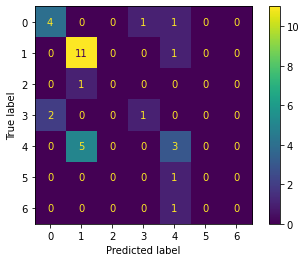

In [295]:
model_predictions2 = model2.predict(val_images)

y_true = [np.argmax(row) for row in val_labels]
y_pred2 = [np.argmax(row) for row in model_predictions2]

matrix = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred2))

matrix.plot()